In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Activation,
    Input,
    BatchNormalization,
    Conv1D,
    Flatten,
    MaxPooling1D,
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping # early stopping
from tensorflow.keras.regularizers import l1
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt
import seaborn as sns

from confusion_matrix import plot_confusion_matrix
sns.set()

In [2]:
from pylab import rcParams

# rcParams['figure.figsize'] = 12, 8

In [3]:
RANDOM_SEED = 333
np.random.seed(RANDOM_SEED)

## Prepare data

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


def one_hot_dna(sequence):
    seq_array = np.array(list(sequence))

    # one hot encoding
    onehot_encoder = OneHotEncoder(sparse=False)
    # reshape because that's what OneHotEncoder likes
    seq_array = seq_array.reshape(len(seq_array), 1)
    onehot_encoded_seq = onehot_encoder.fit_transform(seq_array)
    return onehot_encoded_seq

In [5]:
with open('data_link/L1/data/all_50_last.txt', 'r') as file:
    target_sequences = np.array([line.strip().upper() for line in file.readlines()])
with open('data_link/L1/data/all_shuffled_50_last.txt', 'r') as file:
    non_target_sequences = np.array([line.strip().upper() for line in file.readlines()])
CLASS_NAMES = ['L1', 'Shuffled']

In [6]:
if target_sequences.shape[0] > non_target_sequences.shape[0]:
    target_sequences_n = np.random.choice(
        target_sequences,
        non_target_sequences.shape[0],
    )
    non_target_sequences_n = non_target_sequences
else:
    target_sequences_n = target_sequences
    non_target_sequences_n = np.random.choice(
        non_target_sequences,
        target_sequences.shape[0],
    )



X = np.concatenate((target_sequences_n, non_target_sequences_n))
Y = pd.Series(np.append(
    np.full(target_sequences_n.shape[0], 1),
    np.full(non_target_sequences_n.shape[0], 0))
)


In [7]:
X = np.array([one_hot_dna(line) for line in X])
Y = keras.utils.to_categorical(Y)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=RANDOM_SEED)

In [9]:
X.shape

(13244, 50, 4)

## Model 

In [10]:
print(tf.VERSION)
print(keras.__version__)

1.13.1
2.2.4-tf


In [11]:
num_classes = 2
seq_len = len(X[0]) # 50
nucleotides_count = len(X[0][0]) # 4
epochs = 10
batch_size = 100

In [12]:
model = Sequential()
model.add(Conv1D(50, 5, activation='relu', input_shape=(seq_len, nucleotides_count)))
model.add(MaxPooling1D(3))
# model.add(Conv1D(seq_len, 3, activation='relu',))
# model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 46, 50)            1050      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 50)            0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 50)            0         
_________________________________________________________________
flatten (Flatten)            (None, 750)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                48064     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total para

In [14]:
history = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
)

Train on 8939 samples, validate on 994 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
8939/8939 [==============================] - 0s 48us/sample - loss: 0.3723 - acc: 0.8424 - val_loss: 0.1758 - val_acc: 0.9437
Epoch 2/10
8939/8939 [==============================] - 0s 33us/sample - loss: 0.1565 - acc: 0.9480 - val_loss: 0.0791 - val_acc: 0.9688
Epoch 3/10
8939/8939 [==============================] - 0s 32us/sample - loss: 0.0932 - acc: 0.9701 - val_loss: 0.0519 - val_acc: 0.9829
Epoch 4/10
8939/8939 [==============================] - 0s 32us/sample - loss: 0.0691 - acc: 0.9771 - val_loss: 0.0396 - val_acc: 0.9849
Epoch 5/10
8939/8939 [==============================] - 0s 32us/sample - loss: 0.0581 - acc: 0.9806 - val_loss: 0.0361 - val_acc: 0.9839
Epoch 6/10
8939/8939 [==============================] - 0s 33us/sample - loss: 0.0521 - acc: 0.9819 - val_loss: 0.0320 - val_acc: 0.9869
Epoch 7/10
8939/8939 [==============================] - 0s 32us/sample - loss: 0.04

In [15]:
# New
score = model.evaluate(X_test, Y_test,
                       batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

3311/3311 [==============================] - 0s 10us/sample - loss: 0.0376 - acc: 0.9855


Test score: 0.03761974651967289
Test accuracy: 0.9855029


In [16]:
Y_pred = model.predict_classes(X_test, verbose=1)

3311/3311 [==============================] - 0s 19us/sample


Normalized confusion matrix
[[0.98924088 0.01075912]
 [0.01831502 0.98168498]]


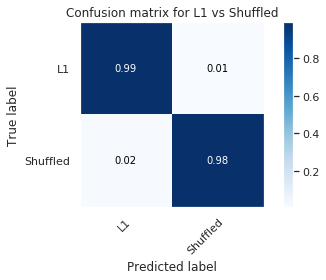

In [17]:
Y_test_flat = np.array(list(map(lambda x: x[1]==1 and 1 or 0, Y_test)))
with sns.axes_style("darkgrid", {"axes.grid": False}):
    plot_confusion_matrix(
        Y_test_flat,
        Y_pred,
        classes=np.array(CLASS_NAMES),
        normalize=True,
        title=f'Confusion matrix for {CLASS_NAMES[0]} vs {CLASS_NAMES[1]}'
    )

In [18]:
Y_pred_probas = model.predict(X_test, verbose=1)[:,1]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test_flat, Y_pred_probas)
auc_keras = auc(fpr_keras, tpr_keras)

3311/3311 [==============================] - 0s 17us/sample


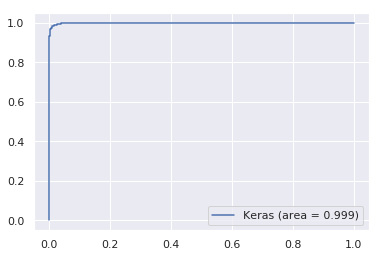

In [19]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.legend(loc='lower right')